In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import shap
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train_prod_df = pd.read_csv(r"C:\Users\Wyatt\wyatt37\Data\hospital\train.csv")
test_prod_df = pd.read_csv(r"C:\Users\Wyatt\wyatt37\Data\hospital\test.csv")
sub = pd.read_csv(r"C:\Users\Wyatt\wyatt37\Data\hospital\submission_sample.csv")

In [5]:
#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
test_prod_df.employee1 = test_prod_df.employee1.astype('str').str.replace(",", "").astype('float')
test_prod_df.employee2 = test_prod_df.employee2.astype('str').str.replace(",", "").astype('float')

In [6]:
#Converting the employee1 and 2 column as float in the train set as done for the test dataset
train_prod_df.employee1 = train_prod_df.employee1.astype('float')
train_prod_df.employee2 = train_prod_df.employee2.astype('float')
train_prod_df.OC= train_prod_df.OC.astype('str').str.replace(" ","")

In [7]:
#Combining the train and test dataset
train_test_prod = train_prod_df.append(test_prod_df)

#Get the object and numeric columns seperately 
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
numeric_columns = train_test_prod.columns.difference(factor_columns)

#After analysis realized that the bed counts of these two hospitals may have had wrong entries.
#Filling up the empty instkind and bedCount for hospital id 430 and 413
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

#Fill the empty values in the object columns as "Not sure"
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')

#Fill all the empty values in the numeric columns as -999
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

In [8]:
#Convert all the object columns to numeric since the ML algorithms don't accept object features directly 
fac_le = LabelEncoder()
train_test_prod[factor_columns] = train_test_prod.loc[:,factor_columns].apply(lambda x : fac_le.fit_transform(x))

#Splitting back data to train prod and test prod
train_prod = train_test_prod.loc[train_test_prod.OC != 0,]
test_prod = train_test_prod.loc[train_test_prod.OC == 0,]
train_prod['OC'] = train_prod['OC'] - 1

#Obtain the submission ID to create the submission file later
sub_id = test_prod.inst_id

#Get the dependent and independent column
dep = 'OC'
indep = train_prod.columns.difference([dep])


train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
############################################################################
############ Random Forest
############################################################################
estimators = 10
np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators = estimators)
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

sub_RF = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF = sub_RF[['inst_id', 'OC']]

In [10]:
############################################################################
############ GBM
############################################################################
estimators = 10
np.random.seed(100)
GBM_prod = GradientBoostingClassifier(n_estimators = estimators)
GBM_prod_model = GBM_prod.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction = GBM_prod.predict_proba(test_prod_X)[:,1]

sub_GBM = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction })
sub_GBM = sub_GBM[['inst_id', 'OC']]

[11:03:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




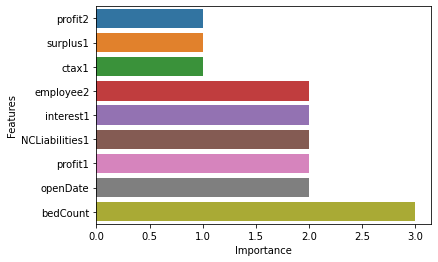

In [12]:
############################################################################
############ XGBOOST
############################################################################
dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
threshold = 0.5
def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds < threshold ).astype('float')
    return "accuracy", accuracy_score(labels, preds)
    

param = {'objective' : 'binary:logistic',
         'max_depth' : 6,
         'eta': 0.3,
         'colsample_bytree' : 1,
         'subsample' : 1,
         'silent' : 0
         }

nrounds = 2

np.random.seed(100)
xgb_model = xgb.train(param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model.predict(dtest_prod)

sub_XGB= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB= sub_XGB[['inst_id', 'OC']]
  
#PLotting the feature importance
xgb_Imp = pd.DataFrame({'Features' : list(xgb_model.get_score().keys()), 
                        'Importance' : list(xgb_model.get_score().values())}).sort_values(['Importance'])
plt.figure()
sns.barplot(xgb_Imp.Importance, xgb_Imp.Features)
plt.show()

In [13]:
############################################################################
#Ensembling the three models
############################################################################

#Forming the ensemble dataset of the 3 models
ensemble = pd.DataFrame()
ensemble['inst_id'] = sub_XGB['inst_id']
ensemble['XGB'] = sub_XGB['OC']
ensemble['GBM'] = sub_GBM['OC']
ensemble['RF'] = sub_RF['OC']

# Taking the average of all 3 models
ensemble['ens'] = (ensemble['XGB'] + ensemble['GBM'] + ensemble['RF'])/3
ensemble['OC'] = (ensemble['ens'] < 0.7).astype('int') #0.7 as the threshold and above that the hospital is closed.

#Printing to see all the hospitals that are classified as closed 
print(ensemble.loc[ensemble['OC'] == 0, ])

ensemble = ensemble.loc[:, ['inst_id', 'OC']]



     inst_id       XGB       GBM   RF       ens  OC
0          2  0.705177  0.966711  0.8  0.823963   0
3          8  0.645067  0.976222  0.8  0.807097   0
4         10  0.705177  0.966711  0.9  0.857296   0
5         12  0.709663  0.976222  1.0  0.895295   0
6         13  0.739121  0.976222  1.0  0.905114   0
..       ...       ...       ...  ...       ...  ..
117      403  0.739121  0.971890  1.0  0.903670   0
118      404  0.739121  0.976222  1.0  0.905114   0
119      410  0.739121  0.976222  1.0  0.905114   0
121      421  0.739121  0.971890  1.0  0.903670   0
125      430  0.645067  0.976222  0.9  0.840430   0

[112 rows x 6 columns]


In [14]:
ensemble.to_csv('./submission/ensemble_bellagio_201230.csv', index = False)

In [15]:
ensemble

,inst_id,OC
0,2,0
1,5,1
2,6,1
3,8,0
4,10,0
...,...,...
122,424,1
123,425,1
124,429,1
125,430,0
